In [1]:
import os
from datasets import load_dataset

data_path = os.path.join(os.getcwd(), 'flower_photos')
dataset = load_dataset("imagefolder", data_dir='/kaggle/input/flower/flower_photos', split="train")
# /kaggle/input/flower/flower_photos
dataset = dataset.rename_column("label", "labels")
dataset

Resolving data files:   0%|          | 0/3670 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-afaf774efcdf77b3/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'labels'],
    num_rows: 3670
})

In [2]:
labels = dataset.features['labels']
labels

ClassLabel(num_classes=5, names=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], id=None)

In [3]:
train_test_valid = dataset.train_test_split(test_size=0.1)
valid = train_test_valid['test']
train_test = train_test_valid['train']

In [4]:
# import random
# from PIL import ImageDraw, ImageFont, Image

# def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

#     w, h = size
#     labels = ds.features['labels'].names
#     grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
#     draw = ImageDraw.Draw(grid)
#     font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

#     for label_id, label in enumerate(labels):

#         # Filter the dataset by a single label, shuffle it, and grab a few samples
#         ds_slice = dataset.filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

#         # Plot this label's examples along a row
#         for i, example in enumerate(ds_slice):
#             image = example['image']
#             idx = examples_per_class * label_id + i
#             box = (idx % examples_per_class * w, idx // examples_per_class * h)
#             grid.paste(image.resize(size), box=box)
#             draw.text(box, label, (255, 255, 255), font=font)

#     return grid

# show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)


In [5]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # or the size used in your model
    transforms.RandomHorizontalFlip(),
])

def process_and_augment(example_batch):
    # Take a list of PIL images, apply augmentations, and turn them to pixel values
    augmented_images = [transform(x) for x in example_batch['image']]
    inputs = processor(augmented_images, return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

# prepared_ds = dataset.with_transform(process_and_augment)
prepared_ds = train_test.with_transform(process_and_augment)

In [7]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [8]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [9]:
from transformers import ViTForImageClassification

labels = dataset.features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-flowers",
  per_device_train_batch_size=48,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=60,
  eval_steps=30,
  logging_steps=1,
  logging_dir='./logs',  # Directory for storing logs
  logging_first_step=True,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [11]:
train_test

Dataset({
    features: ['image', 'labels'],
    num_rows: 3303
})

In [12]:
# split train test
train_test = prepared_ds.train_test_split(test_size=0.1)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
    tokenizer=processor,

)

In [14]:
# display train results graph
%load_ext tensorboard

In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
30,0.340200,0.290515,0.939577
60,0.190200,0.202825,0.960725
90,0.186900,0.174178,0.954683
120,0.232500,0.152344,0.957704
150,0.200300,0.155526,0.954683
180,0.033000,0.196381,0.939577
210,0.101700,0.104055,0.963746
240,0.059900,0.133234,0.951662


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 857980495GF
  train_loss               =      0.1933
  train_runtime            =  0:06:47.17
  train_samples_per_second =      29.196
  train_steps_per_second   =       0.609


In [16]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = list(reversed(example_batch['labels']))
#     print(type(example_batch['labels']))
    return inputs

eval_ds = valid.with_transform(transform)

In [17]:
metrics = trainer.evaluate(eval_ds)
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9619
  eval_loss               =     0.1069
  eval_runtime            = 0:00:08.74
  eval_samples_per_second =     41.986
  eval_steps_per_second   =      5.263


In [28]:
preds = trainer.predict(eval_ds)
predicted_labels = np.array([np.argmax(i) for i in preds.predictions])
actual_labels = np.array(valid['labels'])

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(actual_labels, predicted_labels)


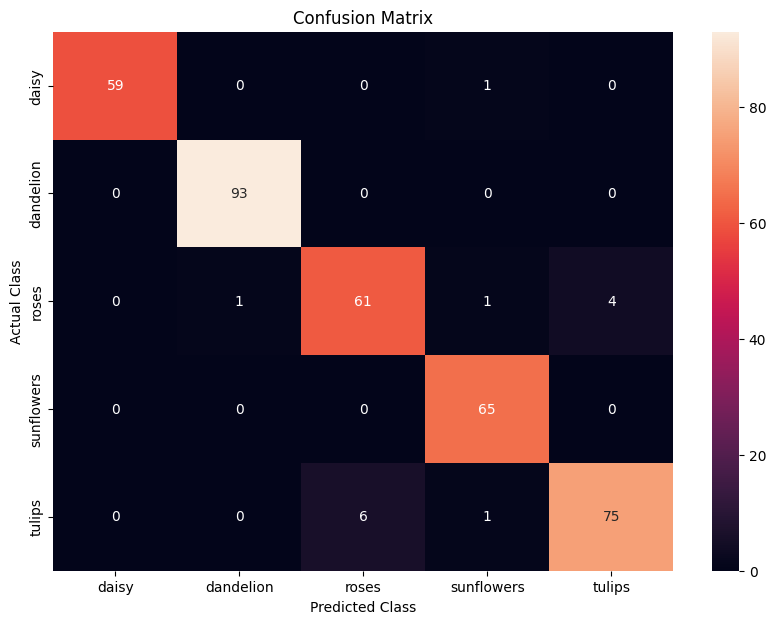

In [42]:
import matplotlib.pyplot as plt

# Modify this list accordingly if you have more classes
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket", xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()

In [40]:
print(classification_report(actual_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

       daisy       1.00      0.98      0.99        60
   dandelion       0.99      1.00      0.99        93
       roses       0.91      0.91      0.91        67
  sunflowers       0.96      1.00      0.98        65
      tulips       0.95      0.91      0.93        82

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367

